In [ ]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import string
import math
import time
import os

# Sklearn libraries for machine learning and text processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_validate, validation_curve, learning_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn import metrics


# NLTK libraries for text processing (lemmatization, stemming, stopwords, POS tagging)
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

# Set up visualization
%matplotlib inline
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# Download necessary NLTK resources for text processing
nltk.download('wordnet')  # WordNet for lemmatization
nltk.download('omw-1.4')  # Open Multilingual Wordnet
nltk.download('punkt')  # Tokenizer
nltk.download('punkt_tab')
nltk.download('stopwords')  # Stopwords for text cleaning
nltk.download('averaged_perceptron_tagger')  # POS tagger for part-of-speech tagging
nltk.download('averaged_perceptron_tagger_eng')  # Additional tagger
nltk.download('tagsets_json')  # Tagset resource

print("\n All libraries imported successfully!")


 All libraries imported successfully!


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagse

**This is where the gihub repo will be cloned, to get the data required.**

In [ ]:
!clone     https://github.com/henry-rob17/I2LLMS_Project1.git

/bin/bash: line 1: clone: command not found


**READ DATASET INTO PANDAS**

In [ ]:
import pandas as pd
df_test = pd.read_csv('/content/Final_test_data.csv')
df_train = pd.read_excel('/content/AI_vs_huam_train_dataset.xlsx')

In [ ]:
!push

/bin/bash: line 1: push: command not found


In [ ]:
import spacy
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


# Load spaCy model without parser/ner for speed
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Pre‐compile regex for mixed alphanumeric detection
_alphanum_re = re.compile(r"(?=.*\d)(?=.*[A-Za-z])")

def text_process(text: str) -> str:
    """
    spaCy‐based preprocessing:
     - lowercase
     - remove stopwords, punctuation, whitespace
     - drop tokens <2 chars
     - drop numeric tokens
     - drop mixed alphanumeric tokens
     - keep only alphabetic tokens
    """
    if not isinstance(text, str):
        return ""

    doc = nlp(text.lower())
    cleaned = []
    for token in doc:
        t = token.text

        if token.is_stop:          # standard stopwords
            continue
        if token.is_punct or token.is_space:
            continue
        if len(t) < 2:
            continue
        if token.like_num:         # pure numeric (ints/floats)
            continue
        if _alphanum_re.search(t): # alphanumeric
            continue
        if not t.isalpha():        # non‐alphabetic symbols
            continue

        cleaned.append(t)

    return " ".join(cleaned)


# Apply text cleaning to the "essay" column
df_train['clean_essays'] = df_train['essay'].apply(text_process)
df_test['clean_essays'] = df_test['essay'].apply(text_process)

# Keep binary labels (AI / Human)
# Filter training data to keep only "Human" and "AI"

binary_mapping = { "AI": 0, "Human": 1 }

# Map labels to numeric vals
df_train['label_num'] = df_train['label'].map(binary_mapping)


Samples: 3728
label
0    1864
1    1864
Name: count, dtype: int64 

        char_count   word_count
count  3728.000000  3728.000000
mean    939.095762   124.160676
std     215.285840    24.541619
min     258.000000    37.000000
25%     802.000000   110.000000
50%     938.000000   124.000000
75%    1072.000000   140.000000
max    1795.000000   221.000000 



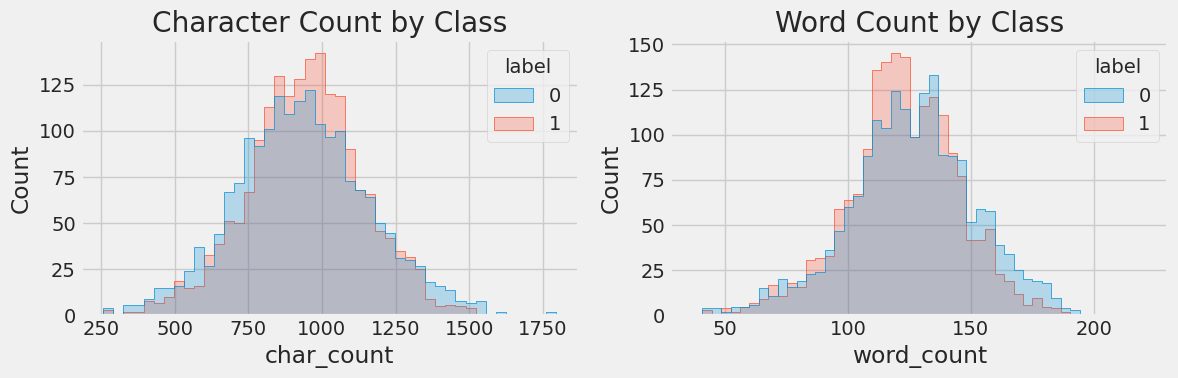

unigrams   → shape: (3728, 7894), features: 7894
bigrams    → shape: (3728, 8978), features: 8978
trigrams   → shape: (3728, 2887), features: 2887
TF-IDF feature matrix: (3728, 10000)
data loaded, cleaned & saved.


In [ ]:
# src/data_preprocessing.py

import os
import re
import pandas as pd
import joblib
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer


# Text‐processing function (spaCy‐based)

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
_alphanum_re = re.compile(r"(?=.*\d)(?=.*[A-Za-z])")

def text_process(text: str) -> str:
    """
    - lowercase
    - remove stopwords, punctuation, whitespace
    - drop tokens <2 chars, numeric, alphanumeric
    - keep only alphabetic tokens
    """
    if not isinstance(text, str):
        return ""
    tokens = []
    for token in nlp(text.lower()):
        t = token.text
        if token.is_stop:            continue
        if token.is_punct or token.is_space:  continue
        if len(t) < 2:               continue
        if token.like_num:           continue
        if _alphanum_re.search(t):   continue
        if not t.isalpha():          continue
        tokens.append(t)
    return " ".join(tokens)



# Load & clean train/test data


TRAIN_PATH   = "/content/AI_vs_huam_train_dataset.xlsx"
TEST_PATH    = "/content/Final_test_data.csv"


def load_and_clean(train_path, test_path):
    # Handle different file types for train and test data
    df_train = pd.read_excel(train_path)
    df_test = pd.read_csv(test_path)

    df_train["clean_essays"] = df_train["essay"].apply(text_process)
    df_train["label_num"]    = df_train["label"]
    df_test["clean_essays"] = df_test["essay"].apply(text_process)


    return df_train, df_test

df_train, df_test = load_and_clean(TRAIN_PATH, TEST_PATH)



# Exploratory Data Analysis (on training set)

def explore(df):

    print("Samples:", len(df))
    print(df.label.value_counts(), "\n")

    # Text length features
    df["char_count"] = df.clean_essays.str.len()
    df["word_count"] = df.clean_essays.str.split().str.len()
    print(df[["char_count","word_count"]].describe(), "\n")

    # Distributions
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    sns.histplot(df, x="char_count", hue="label", ax=axes[0], element="step")
    axes[0].set_title("Character Count by Class")
    sns.histplot(df, x="word_count",  hue="label", ax=axes[1], element="step")
    axes[1].set_title("Word Count by Class")
    plt.tight_layout()
    plt.show()


explore(df_train)



#  n-Gram dimensionality check

corpus = df_train["clean_essays"]
vectorizers = {
    "unigrams":    TfidfVectorizer(ngram_range=(1,1), min_df=3, max_df=0.8),
    "bigrams":     TfidfVectorizer(ngram_range=(2,2), min_df=5, max_df=0.8),
    "trigrams":    TfidfVectorizer(ngram_range=(3,3), min_df=4, max_df=0.8),
}

for name, vect in vectorizers.items():
    X = vect.fit_transform(corpus)
    print(f"{name:10} → shape: {X.shape}, features: {len(vect.get_feature_names_out())}")



# Build & save final TF-IDF for modeling

def build_tfidf(corpus, max_features=10000, ngram_range=(1,2)):
    vect = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=5,
        norm="l2"
    )
    X = vect.fit_transform(corpus)
    return X, vect

X_train, tfidf_vect = build_tfidf(df_train["clean_essays"])
print("TF-IDF feature matrix:", X_train.shape)



print("data loaded, cleaned & saved.")

**SVM**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.svm import SVC

# Text
# Apply text_process only once and let the TfidfVectorizer handle the rest
X_processed = df_train['essay'].apply(text_process)
y = df_train["label"]

pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("classifier", SVC())
])

# Parameter grid
svm_param_grid = [
 {
    'vectorizer__max_features': [10000],
    'vectorizer__ngram_range': [(1,2)],
    'classifier__C': [100],
    'classifier__kernel': ['rbf'],
    'classifier__gamma': [0.01]
  }

]



grid = GridSearchCV(
    estimator=pipeline,
    param_grid=svm_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="accuracy"
)

grid.fit(X_processed, y)    # total run-time was a little over 2 hours

print(grid.best_params_)
print(grid.best_score_)


# Store the best SVM estimator in a variable
best_svm = grid.best_estimator_

#send results to .pkl file

# make sure directory exists
os.makedirs("models", exist_ok=True)

# Dump the tuned SVM pipeline
joblib.dump(best_svm, "models/svm_model.pkl")

print("✔ Saved best SVM to models/svm_model.pkl")





Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'classifier__C': 100, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf', 'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 2)}
0.9664778595462151
✔ Saved best SVM to models/svm_model.pkl


**DECISION TREE**

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

# text processing/filtering
X = df_train["essay"].apply(text_process)
y = df_train["label"]

pipeline_dt = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# Parameter grid
dt_param_grid = {
    "vectorizer__max_features": [10000],
    "vectorizer__ngram_range": [(1,2)],
    "classifier__criterion": ["gini"],
    "classifier__max_depth": [20],
    "classifier__min_samples_split": [10],
    "classifier__min_samples_leaf": [1]
}

grid_dt = GridSearchCV(
    estimator=pipeline_dt,
    param_grid=dt_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="accuracy"
)


grid_dt.fit(X, y)

best_dt = grid_dt.best_estimator_

print("Best parameters:", grid_dt.best_params_)
print("Best CV score:", grid_dt.best_score_)


MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# dump the best estimator
DT_MODEL_PATH = os.path.join(MODEL_DIR, "decision_tree_model.pkl")
joblib.dump(best_dt, DT_MODEL_PATH)

print(f"Saved Decision Tree model to: {DT_MODEL_PATH}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.8463177213595552
Saved Decision Tree model to: models/decision_tree_model.pkl


**ADABOOST**

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

X = df_train["clean_essays"]
y = df_train["label_num"]

# 1) Freeze vectorizer to your “best so far” settings:
fixed_vect = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=5,
    norm="l2"
)

ada_pipe = Pipeline([
    ("vectorizer", fixed_vect),
    ("classifier", AdaBoostClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        random_state=42
    ))
])

# 2) Only tune the AdaBoost parameters:
ada_param_grid = {
    "classifier__n_estimators":     [200],
    "classifier__learning_rate":    [1.0]
}

grid = GridSearchCV(
    ada_pipe,
    param_grid=ada_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring="accuracy"
)

grid.fit(X, y)

print("Best AdaBoost params:", grid.best_params_)
print("Best AdaBoost CV score:", grid.best_score_)

best_ada = grid.best_estimator_


# Check for directory existence
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Path for the AdaBoost model
ADABOOST_MODEL_PATH = os.path.join(MODEL_DIR, "adaboost_model.pkl")

# Dump the best AdaBoost pipeline
joblib.dump(best_ada, ADABOOST_MODEL_PATH)

print(f"Saved AdaBoost model to: {ADABOOST_MODEL_PATH}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best AdaBoost params: {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 200}
Best AdaBoost CV score: 0.8414887453442971
Saved AdaBoost model to: models/adaboost_model.pkl
